# OCR with Keras, TensorFlow, and Deep Learning

## import packages and load datasets

In [ ]:
# import the necessary packages
from tensorflow.keras.datasets import mnist
import numpy as np

In [ ]:
def load_az_dataset():
    a = np.load('/content/drive/MyDrive/Colab Notebooks/A_Z_Handwritten_Data.npz')
    #a = np.load('sample_data/A_Z_Handwritten_Data.npz')
    labels = a['labels']
    data = a['images'].reshape((labels.shape[0], 28, 28)).astype(np.float32)
    return data, labels

In [ ]:
def load_mnist_dataset():
    # load the MNIST dataset and stack the training data and testing
    # data together (we'll create our own training and testing splits
    # later in the project)
    (trainData, trainLabels), (testData, testLabels) = mnist.load_data()
    data = np.vstack([trainData, testData])
    labels = np.hstack([trainLabels, testLabels])
    # return a 2-tuple of the MNIST data and labels
    return data, labels

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
#from pyimagesearch.models import ResNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt, matplotlib.cm as cm
import numpy as np
import argparse
import cv2

In [ ]:
# load the A-Z dataset
print("[INFO] loading A-Z dataset...")
azData, azLabels = load_az_dataset()

[INFO] loading A-Z dataset...


In [ ]:
# load the MNIST dataset
print("[INFO] loading 0-9 dataset...")
digitsData, digitsLabels = load_mnist_dataset()

[INFO] loading 0-9 dataset...
11493376/11490434 [==============================] - 0s 0us/step


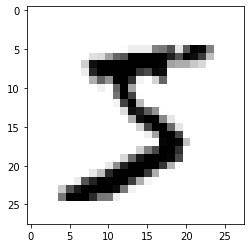

In [ ]:
%matplotlib inline
plt.imshow(digitsData[0], cmap=cm.gray_r)
plt.show()

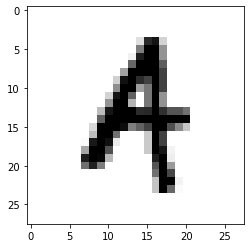

In [ ]:
plt.imshow(azData[0], cmap=cm.gray_r)
plt.show()

## Prepare the data for ResNet

In [ ]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every
# A-Z label to ensure the A-Z characters are not incorrectly labeled
# as digits
azLabels += 10
# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])
# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")
# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

(442451, 32, 32, 1)


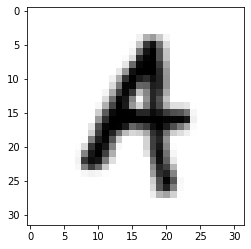

In [ ]:
print(data.shape)
plt.imshow(np.squeeze(data[0]), cmap=cm.gray_r)
plt.show()

In [ ]:
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
print(labels[0])  # correspond to A
counts = labels.sum(axis=0)

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
print(classTotals)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]

[ 6903  7877  6990  7141  6824  6313  6876  7293  6825  6958 13870  8668
 23409 10134 11440  1163  5762  7218  1120  8493  5603 11586 12336 19010
 57825 19341  5812 11566 48419 22495 29008  4182 10784  6272 10859  6076]


In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.20, stratify=labels, random_state=42)

In [ ]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest")

## ResNet model implementation with keras and tensorflow

In [ ]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

Model parameters

In [ ]:
# number of epochs
EPOCHS = 50
# initial learning rate
INIT_LR = 1e-1
# batch size
BS = 128

In [ ]:
class ResNet:

    @staticmethod
    def residual_module(data, K, stride, chanDim, red=False, reg=0.0001, bnEps=2e-5, bnMom=0.9):
        
        # the shortcut branch of the ResNet module should be initialize as the input (identity) data
        shortcut = data
        
        # the first block of the ResNet module are the 1x1 CONVs
        bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(data)
        act1 = Activation("relu")(bn1)
        conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act1)
        
        # the second block of the ResNet module are the 3x3 CONVs
        bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(conv1)
        act2 = Activation("relu")(bn2)
        conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride, padding="same", 
                       use_bias=False, kernel_regularizer=l2(reg))(act2)
        
        # the third block of the ResNet module is another set of 1x1 CONVs
        bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(conv2)
        act3 = Activation("relu")(bn3)
        conv3 = Conv2D(K, (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act3)
        
        # if we are to reduce the spatial size, apply a CONV layer to the shortcut
        if red:
            shortcut = Conv2D(K, (1, 1), strides=stride, use_bias=False, kernel_regularizer=l2(reg))(act1)
        
        # add together the shortcut and the final CONV
        x = add([conv3, shortcut])
        
        # return the addition as the output of the ResNet module
        return x
    
    @staticmethod
    def build(width, height, depth, classes, stages, filters, reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
        
        # initialize the input shape to be "channels last" and the channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1
        
        # if we are using "channels first", update the input shape and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # set the input and apply BN
        inputs = Input(shape=inputShape)
        x = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(inputs)
        
        # check if we are utilizing the CIFAR dataset
        if dataset == "cifar":
            # apply a single CONV layer
            x = Conv2D(filters[0], (3, 3), use_bias=False, padding="same", kernel_regularizer=l2(reg))(x)
        
        # loop over the number of stages
        for i in range(0, len(stages)):
            # initialize the stride, then apply a residual module used to reduce the spatial size of the input volume
            stride = (1, 1) if i == 0 else (2, 2)
            x = ResNet.residual_module(x, filters[i + 1], stride, chanDim, red=True, bnEps=bnEps, bnMom=bnMom)
        
            # loop over the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a ResNet module
                x = ResNet.residual_module(x, filters[i + 1], (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)
        
        # apply BN => ACT => POOL
        x = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = AveragePooling2D((8, 8))(x)
        
        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer=l2(reg))(x)
        x = Activation("softmax")(x)
        
        # create the model
        model = Model(inputs, x, name="resnet")
        
        # return the constructed network architecture
        return model

In [ ]:
# initialize and compile our deep neural network
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3), (64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


## Train the network

In [ ]:
print("[INFO] training network...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS,
    class_weight=classWeight,
    verbose=1)

[INFO] training network...
Epoch 1/50
2765/2765 [==============================] - 163s 56ms/step - loss: 3.8381 - accuracy: 0.7612 - val_loss: 0.4922 - val_accuracy: 0.9170
Epoch 2/50
2765/2765 [==============================] - 154s 56ms/step - loss: 0.9500 - accuracy: 0.9267 - val_loss: 0.5264 - val_accuracy: 0.8972
Epoch 3/50
2765/2765 [==============================] - 156s 56ms/step - loss: 0.8614 - accuracy: 0.9345 - val_loss: 0.5689 - val_accuracy: 0.8773
Epoch 4/50
2765/2765 [==============================] - 157s 57ms/step - loss: 0.8119 - accuracy: 0.9377 - val_loss: 0.6025 - val_accuracy: 0.8639
Epoch 5/50
2765/2765 [==============================] - 158s 57ms/step - loss: 0.7854 - accuracy: 0.9399 - val_loss: 0.5266 - val_accuracy: 0.8948
Epoch 6/50
2765/2765 [==============================] - 157s 57ms/step - loss: 0.7670 - accuracy: 0.9415 - val_loss: 0.5346 - val_accuracy: 0.8922
Epoch 7/50
2765/2765 [==============================] - 157s 57ms/step - loss: 0.7544 - acc

In [ ]:
# save the model to disk
print("[INFO] saving network to the disk")
model.save('/content/drive/MyDrive/Colab Notebooks/ResNet_model.h5', save_format="h5")

[INFO] saving network to the disk


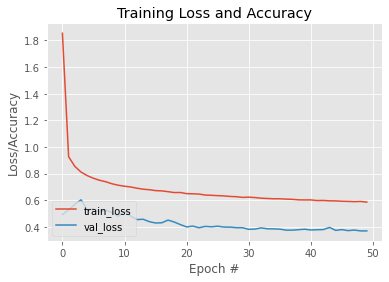

In [ ]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.figure()
plt.plot(N, H.history['loss'], label='training loss')
plt.plot(N, H.history['val_loss'], label='validation loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

## Evaluate the network

In [ ]:
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.70      0.39      0.50      1381
           1       0.98      0.99      0.99      1575
           2       0.92      0.97      0.94      1398
           3       0.99      0.99      0.99      1428
           4       0.93      0.97      0.95      1365
           5       0.68      0.95      0.79      1263
           6       0.97      0.98      0.97      1375
           7       0.98      0.99      0.98      1459
           8       0.98      0.99      0.98      1365
           9       0.99      0.98      0.98      1392
           A       0.99      0.99      0.99      2774
           B       0.99      0.99      0.99      1734
           C       0.99      0.99      0.99      4682
           D       0.92      0.98      0.95      2027
           E       0.99      0.99      0.99      2288
           F       0.96      0.99      0.97       232
           G       0.97      0.96      0.96      115

In [ ]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(testY.argmax(axis=1), predictions.argmax(axis=1))

In [ ]:
# normalized confusion matrix
row_sums = conf.sum(axis=1)
norm_conf = conf / row_sums

# error rates matrix
err_rates_matrix = conf / conf.sum(axis=1, keepdims=1)
np.fill_diagonal(err_rates_matrix, 0)

Text(0.5, 1.0, 'confusion matrix')

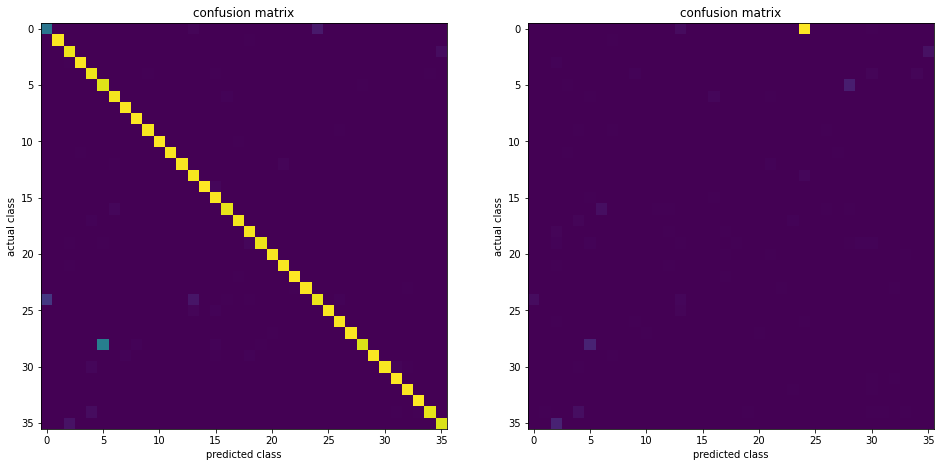

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(norm_conf)
plt.xlabel('predicted class')
plt.ylabel('actual class')
plt.title('confusion matrix')
plt.subplot(122)
plt.imshow(err_rates_matrix)
plt.xlabel('predicted class')
plt.ylabel('actual class')
plt.title('confusion matrix')

## Visualize the results

In [ ]:
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ResNet_model.h5')

In [ ]:
testY.shape

(88491, 36)

In [ ]:
model.predict(testX[np.newaxis, 4]).argmax(axis=1)

array([4])

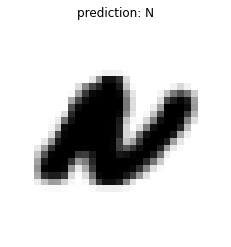

In [ ]:
i = np.random.randint(testY.shape[0])
plt.imshow(np.squeeze(testX[i]), cmap=cm.gray_r)
plt.title('prediction: %s' % labelNames[model.predict(testX[np.newaxis, i]).argmax(axis=1)[0]])
plt.axis('off')
plt.show()

In [ ]:
# initialize our list of output test images
images = []

# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
    # classify the character
    probs = model.predict(testX[np.newaxis, i])
    prediction = probs.argmax(axis=1)
    label = labelNames[prediction[0]]
    # extract the image from the test data and initialize the text
    image = (testX[i] * 255).astype('uint8')
    # label color as green (correct)
    color = (0, 255, 0)
    # otherwise, the class label prediction is incorrect
    if prediction[0] != np.argmax(testY[i]):
      color = (0, 0, 255)
    # merge the channels into one image, resize the image from 32x32
    # to 96x96 so we can better see it and then draw the predicted
    # label on the image
    image = cv2.merge([image] * 3)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
    # add the image to our list of output images
    images.append(image)
print(len(images))

49


In [ ]:
def image_mosaic(image_list, image_shape, montage_shape):
    image_montages = []
    # start with black canvas to draw images onto
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        start_new_img = False
        img = cv2.resize(img, image_shape)
        # draw image to black canvas
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # reset black canvas
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_montages.append(montage_image)  # add unfinished montage
    return image_montages

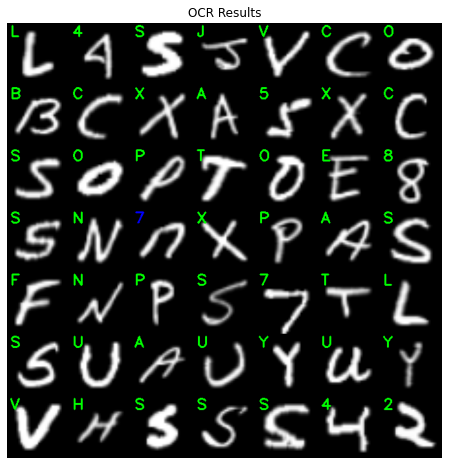

In [ ]:
import cv2

# construct the mosaic with the images
mosaic = image_mosaic(images, (96, 96), (7, 7))[0]
# show the output montage
plt.figure(figsize=(8, 8))
plt.imshow(mosaic)
plt.title('OCR Results')
plt.axis('off')
plt.show()


## Test on a real world image

(756, 1008, 3)


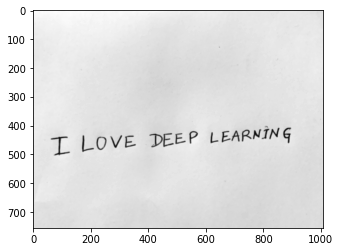

In [ ]:
import cv2

# load the input image from disk, convert it to grayscale, and blur
# it to reduce noise
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/image_OCR9.jpg')
image = cv2.resize(image, (int(image.shape[1] * 0.25), int(image.shape[0] * 0.25)))
print(image.shape)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap=cm.gray)

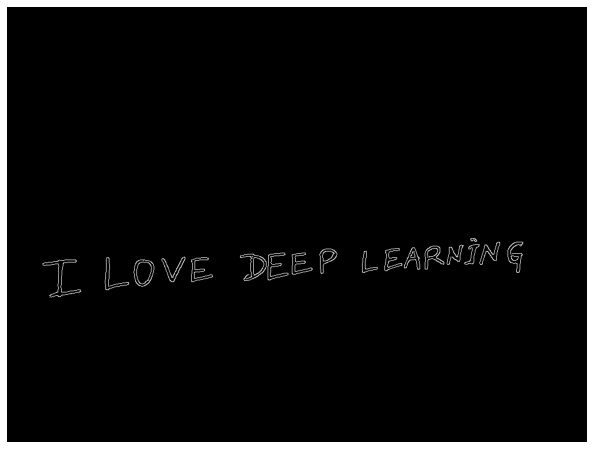

In [ ]:
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 0, 255)
plt.figure(figsize=(12, 8))
plt.imshow(edged, cmap=cm.gray)
plt.axis('off')
plt.show()

In [ ]:
contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
print('%d contours detected' % len(contours))

# grab the bounding boxes of each contour
bounding_boxes = [cv2.boundingRect(c) for c in contours]

# sort the contours from top-left to bottom-right
contours, bounding_boxes = zip(*sorted(zip(contours, bounding_boxes), key=lambda c: c[1][0]))

20 contours detected


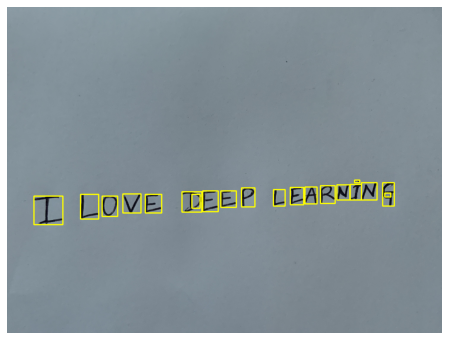

In [ ]:
# loop over the predictions and bounding box locations together
for i in range(len(bounding_boxes)):
    (x, y, w, h) = bounding_boxes[i]
    # draw the bounding box on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 0), 2)
# show the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# list of characters to process
chars = []

# loop over the contours
for c in contours:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    print(x, y, w, h)

    # filter out bounding boxes, ensuring they are neither too small or too large
    #if (w < 10 or w > 200 or h < 100 or h > 200):  # image 8
    if (w < 25 or w > 200 or h < 30 or h > 100):  # image 9
      continue

    # extract the character 
    roi = gray[y:y + h, x:x + w]

    # threshold and inverse the character
    thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    (tH, tW) = thresh.shape

    # resize to 32 pixels
    if tW > tH:
      thresh = cv2.resize(thresh, (32, int(tH * 32 / tW)))
    else:
      thresh = cv2.resize(thresh, (int(tW * 32 / tH), 32))
    print('resized to ', thresh.shape)

    # pad the image to 32 x 32
    (tH, tW) = thresh.shape
    dX = int(max(0, 32 - tW) / 2.0)
    dY = int(max(0, 32 - tH) / 2.0)
    padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
      left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
      value=(0, 0, 0))
    padded = cv2.resize(padded, (32, 32))
    
    # prepare the image to be processed by the model
    padded = padded.astype('float32') / 255.0
    padded = np.expand_dims(padded, axis=-1)

    # update our list of characters that will be OCR'd
    chars.append((padded, (x, y, w, h)))


62 439 67 66
resized to  (31, 32)
170 435 42 57
resized to  (32, 23)
220 439 36 47
resized to  (32, 24)
268 434 42 44
resized to  (32, 30)
320 435 38 43
resized to  (32, 28)
405 429 46 47
resized to  (32, 31)
428 435 19 32
453 427 36 48
resized to  (32, 24)
495 427 36 38
resized to  (32, 30)
543 420 31 44
resized to  (32, 22)
617 424 27 38
resized to  (32, 22)
656 419 31 40
resized to  (32, 24)
690 418 28 39
resized to  (32, 22)
726 415 34 41
resized to  (32, 26)
764 413 30 35
resized to  (32, 27)
795 412 26 36
resized to  (32, 23)
805 402 12 6
821 408 36 40
resized to  (32, 28)
870 408 27 54
resized to  (32, 16)
875 432 14 9


In [ ]:
# put all characters in a single array to be processed by the model
characters = np.array([c[0] for c in chars], dtype='float32')
print(characters.shape)

(17, 32, 32, 1)


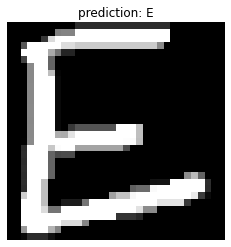

In [ ]:
i = 4
plt.imshow(np.squeeze(characters[i]), cmap=cm.gray)
label = labelNames[model.predict(np.expand_dims(characters[i], axis=0)).argmax(axis=1)[0]]
plt.title('prediction: %s' % label)
plt.axis('off')
plt.show()

In [ ]:
# now perform OCR on the characters using the model
predictions = model.predict(characters)

In [ ]:
i = 1
print(predictions[i])
labelNames[predictions[i].argmax(axis=0)]

[4.5656439e-09 9.7952439e-03 1.0007926e-04 6.0006817e-09 1.3454414e-06
 4.4815337e-08 4.3968571e-06 6.8300693e-08 5.5844986e-09 1.2434181e-09
 1.8177218e-07 6.8760770e-09 9.6113108e-05 1.4405352e-06 5.7963011e-06
 3.6639409e-07 1.1060873e-06 2.1866304e-06 2.2475013e-04 3.3863431e-05
 1.0448946e-05 9.8952466e-01 1.1822896e-09 8.7346422e-08 2.4844669e-09
 8.7008047e-08 5.0716704e-08 2.8389664e-07 6.6806030e-07 1.2026629e-05
 5.8545815e-05 2.6136928e-07 2.8809344e-08 1.5350688e-06 8.7854524e-08
 1.2430252e-04]


'L'

[INFO] I - 97.53%
[INFO] L - 98.95%
[INFO] D - 63.50%
[INFO] V - 99.99%
[INFO] E - 99.59%
[INFO] D - 99.67%
[INFO] E - 97.83%
[INFO] E - 99.63%
[INFO] P - 97.51%
[INFO] L - 99.80%
[INFO] E - 99.50%
[INFO] A - 99.63%
[INFO] R - 98.65%
[INFO] N - 99.28%
[INFO] I - 82.81%
[INFO] N - 99.96%
[INFO] G - 98.62%


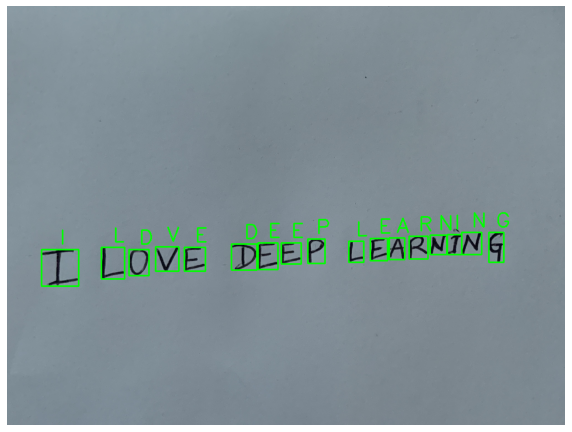

In [ ]:
# loop over the predictions and bounding box locations together
for prediction, (x, y, w, h) in zip(predictions, [c[1] for c in chars]):

    # find the index of the label with the largest probability
    i = prediction.argmax(axis=0)
    prob = prediction[i]

    # extract the label
    label = labelNames[i]

    # draw the prediction on the image
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, label, (x + w // 2, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

plt.figure(figsize=(10, 8)) 
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
labelNames[model.predict(np.expand_dims(padded, axis=0)).argmax(axis=1)[0]]

'E'

In [ ]:
labelNames.index('B')

11

In [ ]:
testY.shape

(88491, 36)

In [ ]:
indices_A = np.where(testY[:, labelNames.index('A')])
indices_B = np.where(testY[:, labelNames.index('B')])
indices_I = np.where(testY[:, labelNames.index('I')])
indices_M = np.where(testY[:, labelNames.index('M')])
indices_N = np.where(testY[:, labelNames.index('N')])

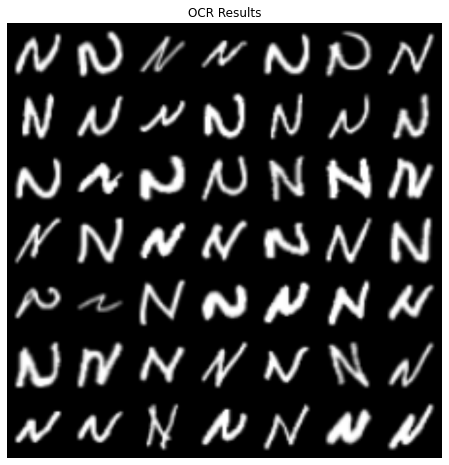

In [ ]:
# show examples of B in the test set
images = []

# randomly select a few testing characters
for i in np.random.choice(indices_N[0], size=(49,)):
    # classify the character
    # extract the image from the test data and initialize the text
    image = (testX[i] * 255).astype('uint8')
    image = cv2.merge([image] * 3)
    images.append(image)

mosaic = image_mosaic(images, (96, 96), (7, 7))[0]
plt.figure(figsize=(8, 8))
plt.imshow(mosaic)
plt.title('OCR Results')
plt.axis('off')
plt.show()